# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.847071,True,5.764113
1,-0.434007,False,-0.338526
2,0.651028,True,5.173650
3,0.206796,True,5.834970
4,0.686597,True,6.724129
...,...,...,...
995,1.043465,True,6.653650
996,0.580309,False,2.602283
997,1.372125,True,6.504697
998,0.560423,True,7.315777


<AxesSubplot:xlabel='v0'>

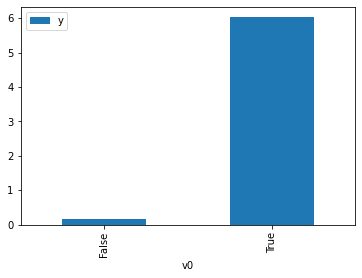

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

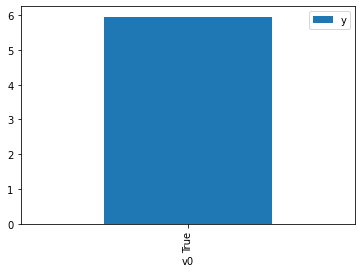

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.373503,False,-2.063875,0.705046,1.418347
1,0.300966,False,-1.085234,0.330601,3.024791
2,-0.270178,False,-0.631542,0.652460,1.532662
3,-0.653574,False,-0.475059,0.821457,1.217349
4,-1.379462,False,-1.862910,0.961705,1.039820
...,...,...,...,...,...
995,-0.043711,False,0.311949,0.525076,1.904485
996,0.549583,False,0.668491,0.216406,4.620948
997,1.296047,False,1.910554,0.046002,21.738039
998,-0.620126,False,0.553588,0.809698,1.235028


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.508195,True,5.197997,0.766736,1.304230
1,0.358705,True,4.924258,0.698562,1.431512
2,0.954988,True,7.578972,0.903312,1.107038
3,1.149259,True,6.508979,0.936361,1.067964
4,2.521958,True,9.575066,0.997263,1.002745
...,...,...,...,...,...
995,1.041624,True,7.568395,0.919615,1.087411
996,-0.054263,True,4.607452,0.468776,2.133215
997,0.394525,True,7.352136,0.715899,1.396846
998,0.779117,True,4.621941,0.860972,1.161478


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          1.496e+04
Date:                Wed, 20 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:52:54   Log-Likelihood:                         -1395.3
No. Observations:                1000   AIC:                                      2795.
Df Residuals:                     998   BIC:                                      2804.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4937      0.038     39.785      0.000       1.420       1.567
x2             5.0532      0.052     96.440      0.000       4.950       5.156
==============================================================================
Omnibus:                        1.464   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.516
Skew:                           0.090   Prob(JB):                        0.468
Kurtosis:                       2.939   Cond. No.                         2.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""